![Colegio Bourbaki](./Images/Bourbaki.png)

## Procesamiento de Lenguaje Natural

### Resumenes de texto utilizando RNN

Las opiniones de los clientes suelen ser largas y descriptivas. Analizar estas opiniones manualmente, como pueden imaginar, lleva mucho tiempo. Aquí es donde se puede aplicar Procesamiento del Lenguaje Natural para generar un resumen de las reseñas largas.

Trabajaremos con un conjunto de datos realmente interesante. Nuestro objetivo aquí es generar un resumen para las reseñas de Amazon Fine Food un modelo DE REDES NEURONALES RECURRENTES con Redes LSTM (Long-Short-Term-Memory)

In [1]:
#Data Analysis
import numpy as np
import pandas as pd

#Text preprocessing
import contractions
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Tokenizer
import sentencepiece as spm

#Data Loading
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

# Utils
import os
import sys
from sklearn.model_selection import train_test_split
#from torchsummary import summary
from tqdm.notebook import tqdm  # Display progress bar

## Configuraciones

In [2]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda:0'

In [6]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__, end="\n\n")

if torch.cuda.is_available():
    #print("__CUDA VERSION")
    #! nvcc --version
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__Devices:")
    print("Active CUDA Device: GPU", torch.cuda.current_device())
    print("Available devices ", torch.cuda.device_count())
    print("Current cuda device ", torch.cuda.current_device())
    #! nvidia-smi

__Python VERSION: 3.11.7 (main, Dec 29 2023, 12:40:11) [GCC 11.4.0]
__pyTorch VERSION: 2.1.2+cu121

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__Devices:
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [7]:
pd.set_option("display.max_colwidth", 200)

### Carga de Datos

Este conjunto de datos está formado por reseñas de alimentos selectos de Amazon. Los datos abarcan un periodo de más de 10 años e incluyen todas las ~500.000 reseñas hasta octubre de 2012. Estas reseñas incluyen información sobre el producto y el usuario, valoraciones, reseñas en texto sin formato y resúmenes. También incluye reseñas de todas las demás categorías de Amazon.

Tomaremos una muestra de 100.000 reseñas para reducir el tiempo de entrenamiento de nuestro modelo. No dudes en utilizar el conjunto de datos completo para entrenar tu modelo si tu máquina dispone de esa potencia de cálculo.

In [8]:
data = pd.read_csv("./Data/Reviews.csv", low_memory=False)

In [9]:
data = data.sample(n=100000, random_state=42) 

In [10]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,"Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch. They're crunchy and true to the texture of the other ""real"" cookies that aren't gluten-free..."
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,"My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was hiding to come get a treat. She doesn't like crunchy treats much, so thes..."
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to have a muddy taste - not what I expected since they said it was the favorite of the company.
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in original size, then there was Frosted Mini-Wheats Bite Size. Well, if for some reason those were too much of a mouthful, we now have Frosted Mini-Wheats Lit..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,"and I want to congratulate the graphic artist for putting the entire product name on such a small box. The ad men must have really thought long and hard.<br /><br />But seriously, I love the prod..."


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 165256 to 174904
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99997 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99991 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.4+ MB


Vamos a desprendernos de las reseñas nulas y de las mismas que se repitan

In [12]:
data.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   9
Text                      0
dtype: int64

In [13]:
# Drop Duplicates
data.drop_duplicates(subset=["Text"], inplace=True)
data = data.dropna()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87587 entries, 165256 to 174904
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      87587 non-null  int64 
 1   ProductId               87587 non-null  object
 2   UserId                  87587 non-null  object
 3   ProfileName             87587 non-null  object
 4   HelpfulnessNumerator    87587 non-null  int64 
 5   HelpfulnessDenominator  87587 non-null  int64 
 6   Score                   87587 non-null  int64 
 7   Time                    87587 non-null  int64 
 8   Summary                 87587 non-null  object
 9   Text                    87587 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [15]:
df = pd.DataFrame(data, columns=["Summary", "Text"])

In [16]:
del data

In [17]:
df.head()

,Summary,Text
165256,Crunchy & Good Gluten-Free Sandwich Cookies!,"Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch. They're crunchy and true to the texture of the other ""real"" cookies that aren't gluten-free..."
231465,great kitty treats,"My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was hiding to come get a treat. She doesn't like crunchy treats much, so thes..."
427827,COFFEE TASTE,A little less than I expected. It tends to have a muddy taste - not what I expected since they said it was the favorite of the company.
433954,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in original size, then there was Frosted Mini-Wheats Bite Size. Well, if for some reason those were too much of a mouthful, we now have Frosted Mini-Wheats Lit..."
70260,Great Taste . . .,"and I want to congratulate the graphic artist for putting the entire product name on such a small box. The ad men must have really thought long and hard.<br /><br />But seriously, I love the prod..."


### Preprocesamiento

Es muy importante realizar unos pasos básicos de preprocesamiento antes de pasar a la parte de construcción del modelo. Utilizar datos de texto desordenados y sin limpiar es un paso potencialmente desastroso. En este paso, eliminaremos del texto todos los símbolos, caracteres, etc. no deseados que no afecten al objetivo de nuestro problema.

Realizaremos las siguientes tareas de preprocesamiento de nuestros datos:

* Convertir todo a minúsculas
* Eliminar las etiquetas HTML
* Mapear Contracciones
* Eliminar ('s)
* Eliminar cualquier texto dentro del paréntesis ( )
* Eliminar puntuaciones y caracteres especiales
* Eliminar palabras vacías
* Eliminar palabras cortas

#### Preprocesar texto

In [18]:
stop_words = set(stopwords.words("english"))
html_tags_pattern = re.compile(r'<.*?>')

In [19]:
def text_cleaner(text):
    """
    Clean text column in the dataset.
    """
    # Remove HTML tags
    new_string =  re.sub(html_tags_pattern, '', text)
    # Remove quotes
    new_string = re.sub(r'"', "", new_string)
    # Expand contractions using the dictionary
    new_string = contractions.fix(new_string)
    # Remove possessive 's
    new_string = re.sub(r"'s\b", "", new_string)
    # Lowercase words
    new_string = new_string.lower()
    # Remove non-alphabetic characters and short words, filter stop words
    tokens = [
        w
        for w in re.findall(r"\b\w+\b", new_string)
        if len(w) >= 3 and w not in stop_words
    ]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join long words
    cleaned_text = " ".join(tokens).strip()
    
    return cleaned_text

b) Summary Cleaning

In [20]:
def summary_cleaner(text):
    """
    Clean summary column in dataset
    """
    # Remove quotes
    new_string = re.sub('"', "", str(text))
    # Expand contractions using the dictionary
    new_string = contractions.fix(new_string)
    # Remove possessive 's
    new_string = re.sub(r"'s\b", "", new_string)
    # Match all strings that contain a non-letter
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    # Lowercase words
    new_string = new_string.lower()
    # Tokenization
    tokens = new_string.split()
    # Remove shortwords
    #new_string = " ".join([i for i in tokens if len(i) > 1])
    new_string = " ".join([i for i in tokens])
    
    return new_string

In [21]:
%%time
df["Text"] = df["Text"].apply(text_cleaner)
df["Summary"] = df["Summary"].apply(summary_cleaner)
# Lo hacemos in-place

CPU times: user 18.8 s, sys: 19.7 ms, total: 18.8 s
Wall time: 18.8 s


In [22]:
df['Summary'] = df['Summary'].apply(lambda x : 'sot ' + x + ' eot')  #Identificador de comienzo y término

In [23]:
df.head()

,Summary,Text
165256,sot crunchy good gluten free sandwich cookies eot,tried couple brand gluten free sandwich cooky best bunch crunchy true texture real cooky gluten free might think filling make bit sweet mean satisfied sweet tooth sooner chocolate version glutino ...
231465,sot great kitty treats eot,cat love treat ever cannot find house pop top bolt wherever hiding come get treat like crunchy treat much perfect given three flavor seems like equally tend dry time near end bottle however flip t...
427827,sot coffee taste eot,little le expected tends muddy taste expected since said favorite company
433954,sot so the mini wheats were too big eot,first frosted mini wheat original size frosted mini wheat bite size well reason much mouthful frosted mini wheat little bit yes half size bite size version particular one cinnamon roll nothing new...
70260,sot great taste eot,want congratulate graphic artist putting entire product name small box men must really thought long hard seriously love product taste refreshing thought taste pleasing aftertaste sweet goldilocks ...


### Distribución de las secuencias
Aquí analizaremos la longitud de las reseñas y del resumen para hacernos una idea general de la distribución de la longitud del texto. 

Esto nos ayudará a fijar la longitud máxima de la secuencia

In [24]:
review_words = df["Text"].apply(lambda x: len(str(x).split()))

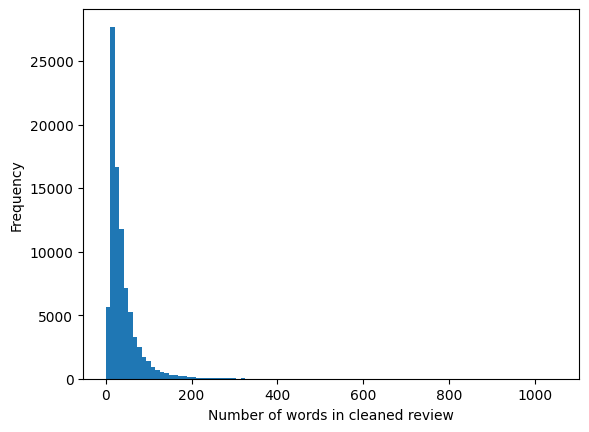

In [25]:
review_words.plot.hist(bins=100)
plt.xlabel("Number of words in cleaned review")
plt.show()

In [26]:
review_words.describe()

count    87587.000000
mean        39.039858
std         38.765453
min          0.000000
25%         16.000000
50%         27.000000
75%         47.000000
max       1051.000000
Name: Text, dtype: float64

In [27]:
p=0.9
print(f"El {100*p:.0f}% de las reseñas tiene {review_words.quantile(p):.0f} palabras")

El 90% de las reseñas tiene 79 palabras


In [28]:
all_text = ' '.join(df['Text'])
rev_unique_words = set(all_text.split())
rev_unique_words = len(rev_unique_words)
print(f"La serie Reseñas tiene {rev_unique_words} palabras únicas")

La serie Reseñas tiene 55543 palabras únicas


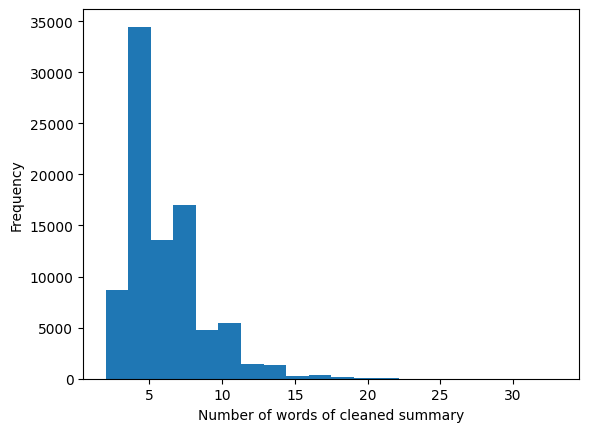

In [29]:
summary_words = df["Summary"].apply(lambda x: len(str(x).split()))
summary_words.plot.hist(bins=20)
plt.xlabel("Number of words of cleaned summary")
plt.show()

In [30]:
summary_words.describe()

count    87587.000000
mean         6.137737
std          2.609361
min          2.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         33.000000
Name: Summary, dtype: float64

In [31]:
print(f"El {100*p:.0f}% de los Resúmenes tiene {summary_words.quantile(p):.0f} palabras")

El 90% de los Resúmenes tiene 10 palabras


In [32]:
all_text = ' '.join(df['Summary'])
sum_unique_words = set(all_text.split())
sum_unique_words = len(sum_unique_words)
print(f"La serie Resumen tiene {sum_unique_words} palabras únicas")

La serie Resumen tiene 15394 palabras únicas


In [33]:
max_len_text = int(review_words.quantile(p))
max_len_summary = int(summary_words.quantile(p))
max_len_text, max_len_summary

(79, 10)

Nos estamos acercando a la parte de construcción del modelo. Antes de eso, tenemos que dividir nuestro conjunto de datos en un conjunto de entrenamiento y otro de validación. Utilizaremos el 80% del conjunto de datos como datos de entrenamiento y evaluaremos el rendimiento con el 20% restante

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    df["Text"], df["Summary"], test_size=0.2, random_state=42, shuffle=True
)

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [36]:
print(
    f"Hay {len(x_train)} reseñas en el conjunto de entrenamiento, {len(x_val)} en validación y {len(x_test)} reseñas en el conjunto de prueba"
)

Hay 63062 reseñas en el conjunto de entrenamiento, 7007 en validación y 17518 reseñas en el conjunto de prueba


### Tokenización

Un tokenizer, en el contexto del procesamiento de lenguaje natural (NLP), es una herramienta que se utiliza para dividir un texto en unidades más pequeñas, llamadas "tokens". Estos tokens suelen ser palabras individuales o partes más pequeñas de las palabras, como subpalabras o caracteres.

La tarea principal de un tokenizer es tomar un texto en lenguaje natural y dividirlo en elementos discretos que puedan ser procesados por algoritmos de NLP. Algunos ejemplos de tokens incluyen:

* **Palabras individuales:** Cada palabra en el texto se considera un token separado. Por ejemplo, en la oración "El perro corre", los tokens son "El", "perro", "corre".

* **Subpalabras o morfemas:** Algunas herramientas de tokenización pueden dividir palabras en partes más pequeñas, como subpalabras o morfemas. Por ejemplo, en la palabra "inflamable", los tokens podrían ser "in-", "flam", y "-able".

* **Caracteres:** En algunos casos, los tokens pueden ser caracteres individuales. Esto se utiliza en el análisis de texto a nivel de caracteres.

La tokenización es un paso fundamental en el procesamiento de lenguaje natural, ya que permite convertir texto en una representación que una computadora puede entender y procesar de manera más efectiva. Los tokens se utilizan como entrada para tareas como análisis de sentimientos, traducción automática, clasificación de texto y muchas otras aplicaciones de NLP.

In [37]:
x_train.to_csv('./Data/Model/x_train.csv', index=False, header=False)

In [38]:
spm_rev_train = spm.SentencePieceTrainer.Train(input='./Data/Model/x_train.csv', model_prefix='./Data/Model/x_train', model_type='word', max_sentence_length=15000, vocab_size=44000)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./Data/Model/x_train.csv
  input_format: 
  model_prefix: ./Data/Model/x_train
  model_type: WORD
  vocab_size: 44000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 15000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differentia

In [39]:
sp_rev = spm.SentencePieceProcessor(model_file='./Data/Model/x_train.model')

In [40]:
# convert text sequences into integer sequences
x_train = list(sp_rev.encode(x_train.to_list()))
x_val = list(sp_rev.encode(x_val.to_list()))
x_test = list(sp_rev.encode(x_test.to_list()))

In [41]:
y_train.to_csv('./Data/Model/y_train.csv', index=False)

In [42]:
spm.SentencePieceTrainer.Train(input='./Data/Model/y_train.csv', model_prefix='./Data/Model/y_train', model_type='word', max_sentence_length=10000, vocab_size=13000)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./Data/Model/y_train.csv
  input_format: 
  model_prefix: ./Data/Model/y_train
  model_type: WORD
  vocab_size: 13000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 10000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differentia

In [43]:
sp_sum = spm.SentencePieceProcessor(model_file='./Data/Model/y_train.model')

In [44]:
y_train = list(sp_sum.encode(y_train.to_list()))
y_val = list(sp_sum.encode(y_val.to_list()))
y_test = list(sp_sum.encode(y_test.to_list()))

### Encajes de Palabras

Puede utilizar modelos Word Embeddings preentrenados como Word2Vec, GloVe o FastText. Estos modelos han sido entrenados en grandes corpus y capturan las relaciones semánticas entre las palabras. Aquí vemos algunos modelos preentrenados que puede utilizar para nuestra tarea:

**GloVe (Vectores Globales para la Representación de Palabras):**
* Fuente: Stanford NLP
* Tamaños: Comúnmente disponibles en tamaños como 50D, 100D, 200D, 300D.
* Descargar: https://nlp.stanford.edu/projects/glove/

**Word2Vec:**
* Fuente: Entrenados por varias organizaciones e investigadores.
* Tamaños: Comúnmente disponibles en tamaños como 50D, 100D, 200D, 300D.
* Descargar: https://code.google.com/archive/p/word2vec/

**FastText:**
* Fuente: Facebook AI Research (FAIR)
* Tamaños: Comúnmente disponibles en tamaños como 50D, 100D, 200D, 300D.
* Descargar: https://fasttext.cc/docs/en/crawl-vectors.html

![Encajes](./Images/WordVectorEmbedding.png)

Fuente: Deep Learning: Chapter 12 - Foundations and Concepts - Christopher Bishop and Hugh Bishop


![CBOW](./Images/CBOWarch.png)

![Skip-Gram](./Images/SGarch.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

En nuestro caso, utilizaremos **GloVe**.

In [45]:
def load_glove_model(glove_file):
    """Load GloVe pre-trained word embeddings into a dictionary."""
    embedding_dict = {}
    with open(glove_file, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype="float32")
            embedding_dict[word] = vector

    return embedding_dict

In [46]:
embedding_bag = load_glove_model("/home/pdconte/Downloads/glove.6B.300d.txt")

In [47]:
# Initialize a list to store the words
rev_voc = []

# Open the file and read its contents
with open('./Data/Model/x_train.vocab', 'r', encoding='utf-8') as file:
    for line in file:
        # Split each line by tab ('\t') to separate the word from the score
        parts = line.strip().split('\t')
        
        # Check if the line has two parts (word and score)
        if len(parts) == 2:
            word = parts[0]
            
            # Remove the first underscore if it exists
            if word.startswith('▁'):
                word = word[1:]
            
            # Append the modified word to the list
            rev_voc.append(word)

In [48]:
# Diccionarios de las reseñas
word_idx_rev = dict(zip(rev_voc, range(len(rev_voc))))
idx_word_rev = {index: word for word, index in word_idx_rev.items()}

In [49]:
sum_voc = []

with open('./Data/Model/y_train.vocab', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            word = parts[0]
            if word.startswith('▁'):
                word = word[1:]
            sum_voc.append(word)

In [50]:
# Diccionarios de los resúmenes
word_idx_sum = dict(zip(sum_voc, range(len(sum_voc))))
idx_word_sum = {index: word for word, index in word_idx_sum.items()}

In [51]:
def word_vectors(dic_vocabulary, dic_embeddings_words, embedding_dim):
    '''Obtiene una matriz donde cada renglón es el 'embedding vector' de una 
    palabra del vocabulario '''
    num_tokens = len(dic_vocabulary)
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    found = 0
    missing_words = []
    
    for word, i in dic_vocabulary.items():
        embedding_vector = dic_embeddings_words.get(word)
        if embedding_vector is not None:
            # Asigna el embedding vector directamente en la matriz
            embedding_matrix[i] = embedding_vector
            found += 1
        else:
            missing_words.append(word)
    
    ratio = found / num_tokens * 100
    print(f"{found} palabras vectorizadas, que representan {ratio:.1f}% de todas las palabras en el corpus")
    return embedding_matrix, missing_words

In [52]:
embedding_matrix_review, missing_words_rev = word_vectors(word_idx_rev, embedding_bag , 300)
embedding_matrix_review.shape

28613 palabras vectorizadas, que representan 65.0% de todas las palabras en el corpus


(44000, 300)

In [53]:
embedding_matrix_summary, missing_words_sum = word_vectors(word_idx_sum, embedding_bag , 300)
embedding_matrix_summary.shape

10660 palabras vectorizadas, que representan 82.0% de todas las palabras en el corpus


(13000, 300)

Vamos a agregar las palabras faltantes a la matrices de embeddings correspondientes.

In [54]:
# Initialize embeddings for the new words
new_embeddings_rev = []
new_embeddings_sum = []

# Initialize embeddings for the new words and add them to the dictionary
for new_word in missing_words_rev[3:]:
    # Initialize the embedding for the new word with random values (dimension: 300)
    new_embedding = np.random.rand(300)
    # Add the new word and its embedding to the list
    new_embeddings_rev.append(new_embedding)

for new_word in missing_words_sum[3:]:
    new_embedding = np.random.rand(300) 
    new_embeddings_sum.append(new_embedding)

new_embeddings_rev = np.array(new_embeddings_rev)
new_embeddings_sum = np.array(new_embeddings_sum)

extended_embedding_matrix_review = np.concatenate((embedding_matrix_review, new_embeddings_rev), axis=0)
extended_embedding_matrix_summary = np.concatenate((embedding_matrix_summary, new_embeddings_sum), axis=0)

In [55]:
extended_embedding_matrix_review.shape, extended_embedding_matrix_summary.shape

((59384, 300), (15337, 300))

### Modelo para resúmenes

ARQUITECTURA RNN:

![RNN](./Images/RNNIO.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

ENCODER:

![E-D](./Images/EncoderDecoder.png)

Fuente: Deep Learning: Chapter 12 - Foundations and Concepts - Christopher Bishop and Hugh Bishop

![LSTM1](./Images/LSTMarch.png)

![LSTM2](./Images/LSTMflow.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

In [56]:
#Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, latent_dim, embedding_matrix, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.num_layer = 1
        self.latent_dim = latent_dim
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.Tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.lstm1 = nn.LSTM(embedding_dim, latent_dim, batch_first=True, num_layers=self.num_layer)
        self.lstm2 = nn.LSTM(embedding_dim, latent_dim, batch_first=True, num_layers=self.num_layer)
        self.dropout = nn.Dropout(dropout_p, inplace=True)

    def forward(self, input_seq):
        self.lstm1.flatten_parameters()
        self.lstm2.flatten_parameters()
        embedded = self.dropout(self.embedding(input_seq))
        #embedded = self.embedding(input_seq)
        encoder_output, encoder_hidden = self.lstm1(embedded)
        encoder_output, encoder_hidden = self.lstm2(embedded, encoder_hidden)
        return encoder_output, encoder_hidden

ATTENTION:

![Attention1](./Images/Attention1.png)

![Attention2](./Images/Attention2.png)

Fuente: Deep Learning: Chapter 12 - Foundations and Concepts - Christopher Bishop and Hugh Bishop

In [57]:
#Attention
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, query, keys):
        keys = keys.type_as(query)
        query = self.Wa(query)
        keys = self.Ua(keys)
        scores = self.Va(torch.tanh(query+keys))
        scores = scores.squeeze(2).unsqueeze(1)
        weights =nn.functional.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

In [58]:
sot=word_idx_sum['sot']
eot=word_idx_sum['eot']

In [59]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, latent_dim, embedding_matrix, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.num_layers = 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.Tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.attention = BahdanauAttention(latent_dim)
        self.lstm = nn.LSTM(embedding_dim+latent_dim, latent_dim, batch_first=True, num_layers=self.num_layers)
        self.out = nn.Linear(latent_dim, vocab_size)
        self.dropout = nn.Dropout(dropout_p, inplace=True)

    def forward(self, encoder_outputs, encoder_hidden, target_size, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(sot)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

   
        for i in range(int(target_size)):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
                )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        self.lstm.flatten_parameters()
        embedded =  self.dropout(self.embedding(input))
        #embedded = self.embedding(input)
        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)
        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

In [70]:
# Define the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_size):
        super(Seq2Seq, self).__init__()
        self.target_size = target_size
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_input, decoder_input, target_size):
        encoder_output, encoder_hidden = self.encoder(encoder_input)
        decoder_output, decoder_hidden, attention_weights = self.decoder(encoder_output, encoder_hidden, target_size, decoder_input)
        return decoder_output, decoder_hidden, attention_weights, encoder_output, encoder_hidden


In [71]:
#Casting a LongTensor
x_train_sequences = [torch.tensor(seq, dtype=torch.long) for seq in x_train]
x_val_sequences = [torch.tensor(seq, dtype=torch.long) for seq in x_val]
x_test_sequences = [torch.tensor(seq, dtype=torch.long) for seq in x_test]
y_train_sequences = [torch.tensor(seq, dtype=torch.long) for seq in y_train]
y_val_sequences = [torch.tensor(seq, dtype=torch.long) for seq in y_val]
y_test_sequences = [torch.tensor(seq, dtype=torch.long) for seq in y_test]
#Padding
x_train_padded = pad_sequence(x_train_sequences, padding_value=0, batch_first=True)[:, :max_len_text]
y_train_padded = pad_sequence(y_train_sequences, padding_value=0, batch_first=True)[:, :max_len_summary]
x_test_padded = pad_sequence(x_test_sequences, padding_value=0, batch_first=True)[:, :max_len_text]
y_test_padded = pad_sequence(y_test_sequences, padding_value=0, batch_first=True)[:, :max_len_summary]
x_val_padded = pad_sequence(x_val_sequences, padding_value=0, batch_first=True)[:, :max_len_text]
y_val_padded = pad_sequence(y_val_sequences, padding_value=0, batch_first=True)[:, :max_len_summary]

In [72]:
train_dataset = TensorDataset(x_train_padded, y_train_padded)
val_dataset = TensorDataset(x_val_padded, y_val_padded)
test_dataset = TensorDataset(x_test_padded, y_test_padded)

In [73]:
# Parametros
input_vocab_size = extended_embedding_matrix_review.shape[0]
output_vocab_size= extended_embedding_matrix_summary.shape[0]
EMB_DIM = 300
HID_DIM = 512
EPOCHS = 10
LR = 0.001
BATCH_SIZE = 256
target_size = 1

In [74]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [75]:
encoder = Encoder(input_vocab_size, EMB_DIM, HID_DIM, extended_embedding_matrix_review)
decoder = Decoder(output_vocab_size, EMB_DIM, HID_DIM, extended_embedding_matrix_summary)

In [76]:
seq2seq = Seq2Seq(encoder, decoder, target_size)
seq2seq.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(59384, 300)
    (lstm1): LSTM(300, 512, batch_first=True)
    (lstm2): LSTM(300, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(15337, 300)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=False)
    )
    (lstm): LSTM(812, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=15337, bias=True)
    (dropout): Dropout(p=0.1, inplace=True)
  )
)

In [77]:
# Define loss function (e.g., cross-entropy loss)
criterion = nn.NLLLoss().to(device)

# Define optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.1)

In [78]:
def train_eval(model, loader, optimizer, loss_func):
    total_loss_train = []
    total_loss_val = []

    # Model in training mode:
    if model.training:
        for batch_idx, (input, target) in tqdm(
            enumerate(loader), desc="Epoch_Train", total=len(loader)
        ):
            
            #Forward pass
            input = input.to(device)
            target = target.to(device)
            output = model(input, target, target.size(1))
            output = output[0].view(-1, output[0].size(-1))
            target = target.view(-1)
            loss_train = loss_func(output, target)
            

            # Backward pass and optimization
            optimizer.zero_grad(set_to_none=True)
            loss_train.backward()
            optimizer.step()
            total_loss_train.append(loss_train.item())

        return total_loss_train

    # Model in evaluation mode:
    elif not model.training:
        for batch_idx, (input, target) in tqdm(
            enumerate(loader), desc="Epoch_Val", total=len(loader)
        ):
            input = input.to(device)
            target = target.to(device)
            output = model(input, target, target.size(1))
            
            output = output[0].view(-1, output[0].size(-1))
            target = target.view(-1)
            loss_val = loss_func(output, target)
            total_loss_val.append(loss_val.item())
        return total_loss_val


def calc_loss(loss_list, total_loss):
    loss_list.append(sum(total_loss) / len(total_loss))
    return loss_list

In [79]:
%%time
# Lists
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
loss_list_train = []
loss_list_val = []

# Training and Evaluation
for epoch in range(EPOCHS):
    # Train Iterations
    seq2seq = seq2seq.train()
    total_loss_train = train_eval(seq2seq, train_loader, optimizer, criterion)

    # Val Iterations
    seq2seq = seq2seq.eval()
    with torch.no_grad():
        total_loss_val = train_eval(seq2seq, val_loader, optimizer, criterion)

    # Calc Loss
    loss_list_train = calc_loss(loss_list_train, total_loss_train)
    loss_list_val = calc_loss(loss_list_val, total_loss_val)

    # Printing Metrics per Epoch
    print(
        f"Training [{100.0 *(epoch+1)/EPOCHS:.0f}%]\t\tTrain Loss:{loss_list_train[-1]:.4f}  Val Loss:{loss_list_val[-1]:.4f}\n")

Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [10%]		Train Loss:3.0991  Val Loss:2.7272



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [20%]		Train Loss:2.6782  Val Loss:2.5544



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [30%]		Train Loss:2.5242  Val Loss:2.4384



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [40%]		Train Loss:2.4233  Val Loss:2.3736



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [50%]		Train Loss:2.3598  Val Loss:2.3294



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [60%]		Train Loss:2.3092  Val Loss:2.2909



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [70%]		Train Loss:2.2695  Val Loss:2.2571



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [80%]		Train Loss:2.2340  Val Loss:2.2280



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [90%]		Train Loss:2.2038  Val Loss:2.2154



Epoch_Train:   0%|          | 0/247 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/28 [00:00<?, ?it/s]

Training [100%]		Train Loss:2.1775  Val Loss:2.1970

CPU times: user 31min 11s, sys: 932 ms, total: 31min 12s
Wall time: 31min 10s


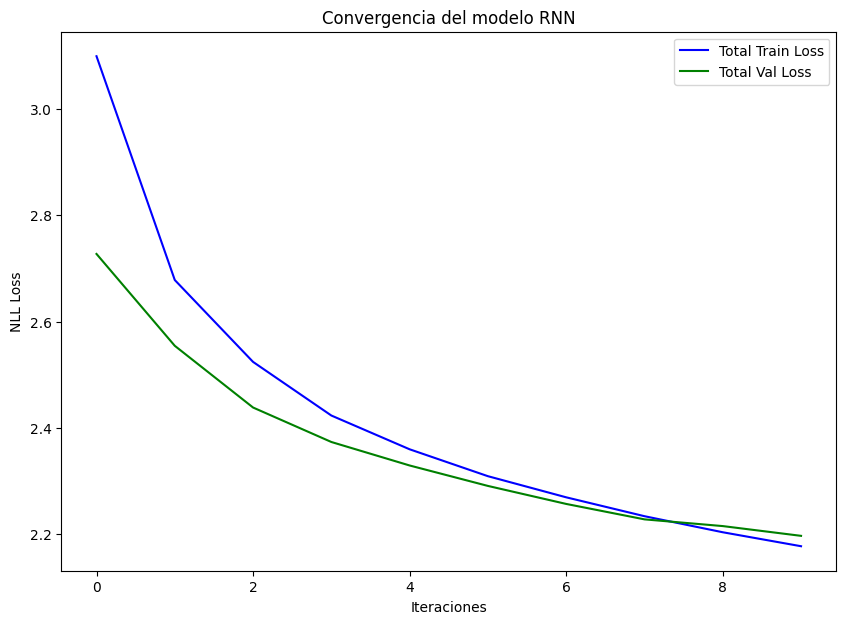

In [80]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(loss_list_train, "b", label="Total Train Loss")
ax1.plot(loss_list_val, "g", label="Total Val Loss")
plt.title("Convergencia del modelo RNN", color="black")
ax1.set_xlabel("Iteraciones")

ax1.set_ylabel("NLL Loss", color="black")
ax1.legend(loc="upper right")
plt.show()

In [81]:
# Save the model state dictionary to a file
torch.save(seq2seq.state_dict(), './Data/Model/s2s_model_2.pth')

### Testing

In [83]:
# Create an instance of your model (with the same architecture)
sq2sq = Seq2Seq(encoder, decoder, target_size)  # Replace with your actual model class

# Load the saved model state dictionary
sq2sq.load_state_dict(torch.load('./Data/Model/s2s_model_2.pth'))

<All keys matched successfully>

In [84]:
y_test_unpadded = []

# Iterate over each sequence in y_test_padded and unpad it
for i, sequence in enumerate(y_test_padded):
    length = len(y_test_sequences[i])
    unpadded_sequence = sequence[:length].tolist()
    y_test_unpadded.append(unpadded_sequence)

In [85]:
detokenizer_rev = spm.SentencePieceProcessor()
detokenizer_rev.load('./Data/Model/x_train.model')
detokenizer_sum = spm.SentencePieceProcessor()
detokenizer_sum.load('./Data/Model/y_train.model')

True

In [86]:
sot, eot

(4, 3)

In [87]:
def generate_summaries(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    generated_summaries = []
    with torch.no_grad():
        # Iterate over batches
        for batch_idx, (input, target) in enumerate(test_loader):

            input = input.to(device)
            target = target.to(device)
            
            # Determine the batch size for this batch
            batch_size = input.size(0)
            
            # Encode the input_sequence using the encoder
            encoder_output, encoder_hidden = model.encoder(input)

            # # Initialize the decoder input with the SOS token for the batch
            # decoder_input = torch.empty(batch_size, len(target[0]), dtype=torch.long, device=device).fill_(sot)

            # Initialize the generated summaries for the batch
            batch_generated_summaries = [[] for _ in range(batch_size)]

            # Run the decoder
            output = model.decoder(encoder_output, encoder_hidden, target.size(1))
                
            # # Get the token with the highest probability
            # top_token = output[0].argmax(dim=2)
            _, topi = output[0].topk(1)
            decoded_ids = topi.squeeze()
            
            # Append the tokens to the generated summaries for each sequence in the batch
            for j in range(batch_size):
                for k in range(decoded_ids.size(1)):
                    batch_generated_summaries[j].append(decoded_ids[j,k].item())
                    if decoded_ids [j,k].item() == eot:
                        break
                   
            # Append the batch of generated summaries to the overall list
            generated_summaries.extend(batch_generated_summaries)


    return generated_summaries


In [88]:
summaries = generate_summaries(sq2sq, test_loader, device)

#### Metrics

In [89]:
from rouge import Rouge
rouge = Rouge()

In [90]:
def remove_tokens(tokens):
    # Filter out "sot" and "eot" tokens from the list of tokens
    return [token for token in tokens if token not in ['sot', 'eot']]

def remove_sot_eot(input_string):
    # Split the input string into words
    words = input_string.split()

    # Remove "sot" and "eot" tokens using the remove_tokens function
    cleaned_words = remove_tokens(words)

    # Join the cleaned words to form the cleaned string
    cleaned_string = ' '.join(cleaned_words)

    return cleaned_string

In [97]:
for i in range(50):
    text = detokenizer_rev.decode(x_test[i])
    summary = detokenizer_sum.decode(y_test[i])
    generated = detokenizer_sum.decode(summaries[i])
    sum_strip = remove_sot_eot(summary)
    gen_strip = remove_sot_eot(generated)
    print(f"Texto {i}: {text}")
    print(f"Resumen {i}: {sum_strip}")
    print(f"Resumen {i} generado: {gen_strip}")
    print(f"ROUGE-1 SCORE: {rouge.get_scores(sum_strip, gen_strip)[0]['rouge-1']} \n")

Texto 0: first time tried dave insanity sauce urging coworkers watched day shaking two three drop onto meal figured could follow suit realized mouth fire late like eating battery acid talk heat sauce pack week building tolerance drop start realize really add heat meal without ruining flavor food like hot sauce still enjoy eating definitely leave sweating word advice wash hand handling bottle picked bottle one time dried side later ⁇  itched eye mistake felt worse getting ⁇ 
Resumen 0: insanity
Resumen 0 generado: not a good as i expected
ROUGE-1 SCORE: {'r': 0.0, 'p': 0.0, 'f': 0.0} 

Texto 1: first bought mix husband celiac disease made pancake bought cuisinart waffle maker tried waffle recipe bag spectacular went camping adult child grandkids dietary restriction could make waffle fast enough also carrot cake recipe bag use make carrot muffin freeze husband carrot muffin coffee anytime want snack wonderful good versatile product shelf anyone whether suffer celiac disease buying amazon

Referencias:

* **Comprehensive Guide to Text Summarization using Deep Learning in Python** - https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

* **NLP From Scratch: Translation with a Sequence to Sequence Network and Attention** - https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#exercises

* **Metrics for evaluating summarization of texts performed by Transformers: how to evaluate the quality of summaries** - https://fabianofalcao.medium.com/metrics-for-evaluating-summarization-of-texts-performed-by-transformers-how-to-evaluate-the-b3ce68a309c3

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)